In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from zipfile import ZipFile
#from skimage.color import ycbcr2rgb
from numpy import pi
from numpy import sin
from numpy import zeros
from numpy import r_
from scipy import signal
from scipy import misc # pip install Pillow
# import imageio
import matplotlib.pylab as pylab
from PIL import Image
import tarfile
import bz2

%matplotlib inline
pylab.rcParams['figure.figsize'] = (20.0, 7.0)

In [2]:
def MSE(original, compressed):
    return np.mean((original - compressed)**2)

def PSNR(original, compressed, num_pixels=255.0):
    mse = MSE(original,compressed)
    if mse == 0:
        return float('inf')
    return 10.0 * np.log10( num_pixels**2 / mse)

In [3]:
def EE123_psnr(ref, meas, maxVal=255):
    assert np.shape(ref) == np.shape(meas), "Test image must match measured image dimensions"
        
    
    dif = (ref.astype(float)-meas.astype(float)).ravel()
    mse = np.linalg.norm(dif)**2/np.prod(np.shape(ref))
    psnr = 10*np.log10(maxVal**2.0/mse)
    return psnr

In [4]:
def dct2(a):
    return scipy.fftpack.dct( scipy.fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )

def idct2(a):
    return scipy.fftpack.idct( scipy.fftpack.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

In [5]:
### for now using basic common matrix 

Ql = np.array( [[16,12,14,14,18, 24, 49, 72],
                [11, 12, 13, 17, 22, 35, 64, 92],
                [10, 14, 16, 22, 37, 55, 78, 95],
                [16, 19, 24, 29, 56, 64, 87, 98],
                [24, 26, 40, 51, 68, 81, 103, 112],
                [40, 58, 57, 87, 109, 104, 121, 100],
                [51, 60, 69, 80, 103, 113, 120, 103],
                [61, 55, 56, 62, 77, 92, 101, 99]]
                ).T

Qc = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
              [18, 21, 26, 66, 99, 99, 99, 99],
              [24, 26, 56, 99, 99, 99, 99, 99],
              [47, 66, 99, 99, 99, 99, 99, 99],
              [99, 99, 99, 99, 99, 99, 99, 99],
              [99, 99, 99, 99, 99, 99, 99, 99],
              [99, 99, 99, 99, 99, 99, 99, 99],
              [99, 99, 99, 99, 99, 99, 99, 99]]).T


print(Qc[(0, 0), (4, 3)])

####### check median cut quantization #########
    
def quantize(U, alpha = 1.):

    s = U.shape
    Y = np.zeros(s)


    for i in r_[:U.shape[0]:8]:
        for j in r_[:U.shape[1]:8]:
            Y[i:(i+8),j:(j+8),0] = (U[i:(i+8),j:(j+8),0] // (alpha*Ql))
    for k in range(1,3):
        for i in r_[:U.shape[0]:8]:
            for j in r_[:U.shape[1]:8]:
                Y[i:(i+8),j:(j+8),k] = (U[i:(i+8),j:(j+8),k] // (alpha*Qc))
    


    return Y

def iquantize(U, alpha=1.):
    
    s = U.shape
    Y = np.zeros(s)

    for i in r_[:U.shape[0]:8]:
        for j in r_[:U.shape[1]:8]:
            Y[i:(i+8),j:(j+8),0] = (U[i:(i+8),j:(j+8),0] * (alpha*Ql))
    for k in range(1,3):
        for i in r_[:U.shape[0]:8]:
            for j in r_[:U.shape[1]:8]:
                Y[i:(i+8),j:(j+8),k] = (U[i:(i+8),j:(j+8),k] * (alpha* Qc))



    return Y


print()

[99 47]
()


In [6]:
def get_size(img_path):
    statinfo = os.stat(img_path)
    print("size of file = " + str(statinfo.st_size) + " Bytes")


In [8]:
rgb_to_YCbCr = np.array([[0.29900, 0.58700, 0.11400],
                       [-0.16874, -0.33126, 0.50000],
                       [0.50000, -0.41869, -0.08131]])

YCbCr_to_rgb = np.linalg.inv(rgb_to_YCbCr)

def rgb2YCbCr(U):
    s = U.shape
    Y = np.zeros(s)
    for i in range(s[0]):
        for j in range(s[1]):
            Y[i,j] = np.dot(rgb_to_YCbCr,U[i,j]) + np.array([[0],[128],[128]])[:,0]
    
    return Y

def rgb2YcbCr_2(R,G,B):
    
    Y = np.zeros(R.shape)
    Cr = np.zeros(R.shape)
    Cb = np.zeros(R.shape)
    
    for i in range(len(R)):
        for j in range(len(R[0])):
            
            Y[i, j] = (.299*R[i, j]) +  (.587 * G[i, j]) +  (.114 * B[i, j])

            Cr[i, j] = (-.16874*R[i, j]) - (.33126 * G[i, j]) +  (.5 * B[i, j]) + 128
            Cb[i, j] = .5*R[i, j]   - (.41869 * G[i, j]) - ( .08131 * B[i, j]) + 128
    
    return Y, Cr, Cb
def YCC2rgb_2(Y,Cr,Cb):
    
    R = np.zeros(Y.shape)
    G = np.zeros(Y.shape)
    B = np.zeros(Y.shape)
    
    for i in range(len(R)):
        for j in range(len(R[0])):
            
            R[i, j] = (YCbCr_to_rgb[0,0]*Y[i, j]) +  (YCbCr_to_rgb[0,1] * (Cr[i, j] - 128)) +  (YCbCr_to_rgb[0,2] * (Cb[i, j] - 128))

            G[i, j] = (YCbCr_to_rgb[1,0]*Y[i, j]) + (YCbCr_to_rgb[1,1] * (Cr[i, j]-128)) +  (YCbCr_to_rgb[1,2] * (Cb[i, j] - 128)) 
            B[i, j] = YCbCr_to_rgb[2,0]*Y[i, j]   + (YCbCr_to_rgb[2,1] * (Cr[i, j]-128)) + ( YCbCr_to_rgb[2,2]* (Cb[i, j] - 128)) 
    
    #return np.uint8(R), np.uint8(G), np.uint8(B)
    return R, G, B
def YCbCr2rgb(U):
    s = U.shape
    Y = np.zeros(s)
    for i in range(s[0]):
        for j in range(s[1]):
            Y[i,j] = np.dot(YCbCr_to_rgb,U[i,j]- np.array([[0],[128],[128]])[:,0]) 
    return Y




[[[185 194 223]
  [188 197 226]
  [191 200 229]
  ..., 
  [179 195 228]
  [181 197 230]
  [ 98 114 147]]

 [[194 203 232]
  [195 205 232]
  [197 206 235]
  ..., 
  [183 200 230]
  [186 203 233]
  [101 118 148]]

 [[198 208 235]
  [199 209 234]
  [199 209 236]
  ..., 
  [189 204 233]
  [192 207 236]
  [104 119 148]]

 ..., 
 [[106  85  68]
  [110  89  72]
  [118  94  81]
  ..., 
  [181 165 142]
  [183 165 143]
  [114  96  74]]

 [[108  84  72]
  [108  84  72]
  [107  83  71]
  ..., 
  [183 166 146]
  [179 161 141]
  [107  86  67]]

 [[100  76  66]
  [104  80  70]
  [111  87  77]
  ..., 
  [176 159 139]
  [176 155 136]
  [108  87  68]]]
DSADSADASDASD
[[[185 194 223]
  [188 197 226]
  [191 200 229]
  ..., 
  [179 195 228]
  [181 197 230]
  [ 98 114 147]]

 [[194 203 232]
  [195 205 232]
  [197 206 235]
  ..., 
  [183 200 230]
  [186 203 233]
  [101 118 148]]

 [[198 208 235]
  [199 209 234]
  [199 209 236]
  ..., 
  [189 204 233]
  [192 207 236]
  [104 119 148]]

 ..., 
 [[106  85  68]
  

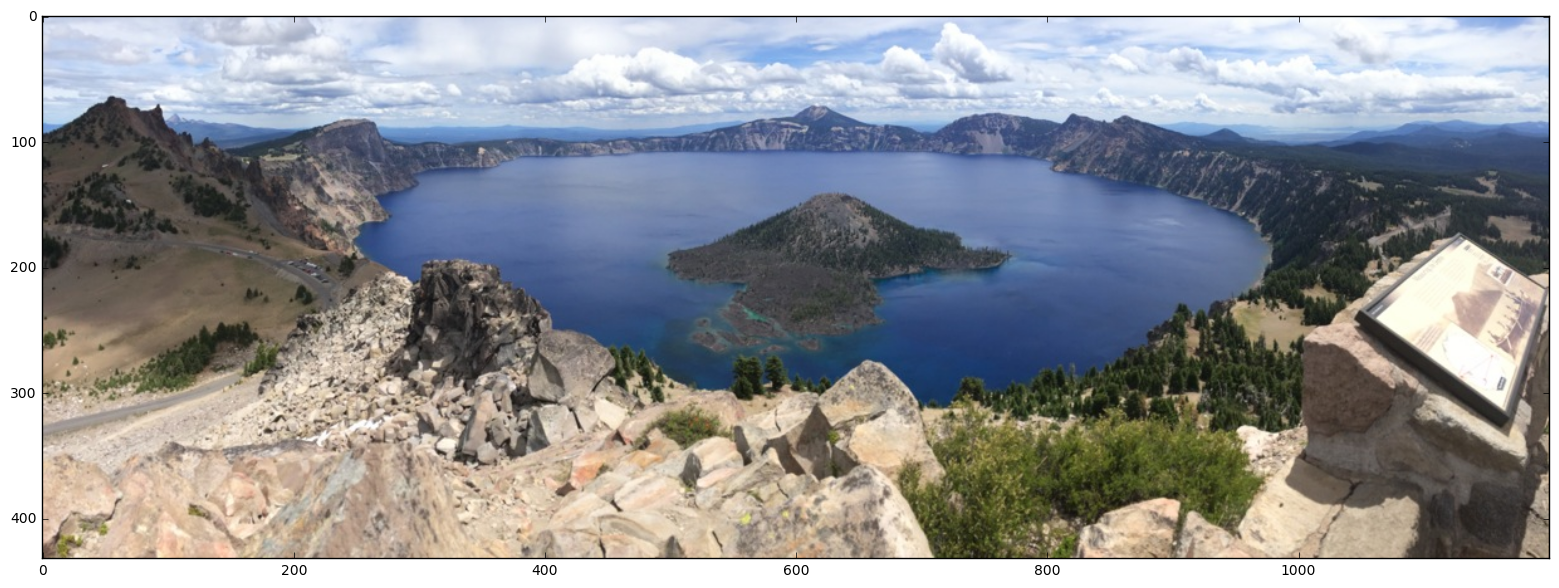

In [9]:
def compress_image(img, thresh,do_quantize = True, thresh_plot = False, modem_bw = 1200 * 75):
    
    
#     if img.nbytes < modem_bw:
#         print("returned original image")
#         return img
        
    #RGB to YCbCr
    iim= rgb2YCbCr(img) 
    #print(iim)
    #print(np.max(iim))
    #print(np.min(iim))
    
    iimsize = iim.shape
    imsize = img.shape
    dct = np.zeros(imsize)
    
    # Do 8x8 DCT on image (in-place)
    for i in r_[:iimsize[0]:8]:
        for j in r_[:iimsize[1]:8]:
            dct[i:(i+8),j:(j+8)] = dct2( iim[i:(i+8),j:(j+8)] )


#     # Threshold
    #if dct[np.nonzero(dct)].nbytes > modem_bw:
    #    print("thresholding")
    #    dct_thresh = dct * (abs(dct) > (thresh*np.max(dct)))
    #else: 
    #    dct_thresh = dct
            
    print("Size of compressed image: " + str(dct[np.nonzero(dct)].nbytes) + " Bytes")
    print("Size of original image: " + str(img.nbytes) + " Bytes")
    print("Precent Compression: " + str(100.*img.nbytes / dct[np.nonzero(dct)].nbytes) + "%")
    
#     print(dct_thresh[:8,0,0])
    if do_quantize:
        #Quantization
        dct_thresh = quantize(dct,1)
        print(dct_thresh)
#         print(dct_thresh[:8,0,0])


    return dct_thresh

def dct_eight(Y, Cr, Cb):
    Y_blocks = np.zeros((Y.shape[0] * Y.shape[1] / 64, 8, 8))
    Cr_blocks = np.zeros((Y.shape[0] * Y.shape[1] / 64, 8, 8))
    Cb_blocks = np.zeros((Y.shape[0] * Y.shape[1] / 64, 8, 8))
    print(Y_blocks.shape)
    k = 0
    for i in range(0, Y.shape[0], 8):
        
        for j in range(0, Y.shape[1], 8):
            
            #Y_blocks[i * (Y.shape[1] / 8) + j] = dct2(Y[i : i + 8, j : j + 8])
            #Cr_blocks[i * (Y.shape[1] / 8) + j] = dct2(Cr[i : i + 8, j : j + 8])
            #Cb_blocks[i * (Y.shape[1] / 8) + j] = dct2(Cb[i : i + 8, j : j + 8])
            Y_blocks[k] = dct2(Y[i : i + 8, j : j + 8])
            Cr_blocks[k] = dct2(Cr[i : i + 8, j : j + 8])
            Cb_blocks[k] = dct2(Cb[i : i + 8, j : j + 8])
            #print(Y_blocks)
            #if k < 15:
            #    print(k)
            #    print("\n")
            #    print(Y_blocks)
            k += 1
    return Y_blocks, Cr_blocks, Cb_blocks
def idct_eight(Y, Cr, Cb, H, W):
    Yn = np.zeros((H, W))
    Crn = np.zeros((H, W))
    Cbn = np.zeros((H, W))
    k= 0
    for i in range(0, H, 8):
        
        for j in range(0, W, 8):

            Yn[i : i + 8, j : j + 8] = idct2(Y[k])
            Crn[i : i + 8, j : j + 8] = idct2(Cr[k])
            Cbn[i : i + 8, j : j + 8] = idct2(Cb[k])
            k += 1
    return Yn, Crn, Cbn

alpha = 1
def quant(Y_b, Cr_b, Cb_b):
    print(Y_b, "\n\n")
    for i in range(len(Y_b)):
        
        curY = Y_b[i]
        curCr = Cr_b[i]
        curCb = Cb_b[i]
        for j in range(8):
            for k in range(8):
                curY[j, k] = float(int(curY[j, k] / Ql[j, k]))
                curCr[j, k] = float(int(curCr[j, k] / Qc[j, k]))
                curCb[j, k] = float(int(curCb[j, k] / Qc[j, k]))
    print(Y_b, "\n\n")
    return Y_b, Cr_b, Cb_b

def iquant(Y_b, Cr_b, Cb_b):
    for i in range(len(Y_b)):
        
        curY = Y_b[i]
        curCr = Cr_b[i]
        curCb = Cb_b[i]
        for j in range(8):
            for k in range(8):
                curY[j, k] = float(int(curY[j, k] * Ql[j, k]))
                curCr[j, k] = float(int(curCr[j, k] * Qc[j, k]))
                curCb[j, k] = float(int(curCb[j, k] * Qc[j, k]))
    return Y_b, Cr_b, Cb_b

def compress_image_2(img):
    h = img.shape[0]
    w = img.shape[1]
    print(h, w)
    
    newH = h
    while newH % 8 != 0:
        newH += 1
    newW = w
    while newW % 8 != 0:
        newW += 1
        
    R = np.zeros((newH, newW))
    G = np.zeros((newH, newW))
    B = np.zeros((newH, newW))
    R[:h,:w] = img[:,:,0]
    #print(R)
    #print(img[:,:,0])
    G[:h,:w] = img[:,:,1]
    B[:h,:w] = img[:,:,2]
    
    Y, Cr, Cb = rgb2YcbCr_2(R, G, B)
    print(Y, Cr, Cb)
    Y_dct, Cr_dct, Cb_dct = dct_eight(Y, Cr, Cb)
    #print(Y_dct)
    Yq, Crq, Cbq = quant(Y_dct, Cr_dct, Cb_dct)
    print(Yq, Crq, Cbq)
    return Yq, Crq, Cbq, newH, newW, h, w

Zigzag = [(0,0), (0, 1), (1, 0), (2, 0), (1, 1), (0, 2), (0, 3), (1, 2), (2, 1), (3, 0), (4, 0), (3, 1), (2, 2), (1, 3), (0, 4), \
            (0, 5), (1, 4), (2, 3), (3, 2), (4, 1), (5, 0), (6, 0), (5, 1), (4, 2), (3, 3), (2, 4), (1, 5), (0, 6), (0, 7), \
            (1, 6), (2, 5), (3, 4), (4, 3), (5, 2), (6, 1), (7, 0), (7, 1), (6, 2), (5, 3), (4, 4), (3, 5), (2, 6), (1, 7), \
            (2, 7), (3, 6), (4, 5), (5, 4), (6, 3), (7, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (4, 7), (5, 6), (6, 5), \
            (7, 4), (7, 5), (6, 6), (5, 7), (6, 7), (7, 6), (7, 7)]

def zig(block):
    

    b = []
    j = 0
    k = 0
    for i in Zigzag:
        if block[i] != 0:
            j = k
        k += 1
    # print(j)
    return np.array([block[Zigzag[i]] for i in range(j+1)])

def undoZig(Y, Cr, Cb):
    newY = np.zeros((len(Y), 8, 8))
    newCr = np.zeros((len(Y), 8, 8))
    newCb = np.zeros((len(Y), 8, 8))
    for i in range(len(Y)):
        curY = newY[i]
        curCr = newCr[i]
        curCb = newCb[i]
        Y_len = len(Y[i])
        Cr_len = len(Cr[i])
        Cb_len = len(Cb[i])
        for j  in range(Y_len):
            curY[Zigzag[j]] = Y[i][j]
        for j  in range(Cr_len):
            curCr[Zigzag[j]] = Cr[i][j]
        for j  in range(Cb_len):
            curCb[Zigzag[j]] = Cb[i][j]
    
    return newY, newCr, newCb
        
        
        
    
def processZig(Y, Cr, Cb):
    newY = []
    newCr = []
    newCb = []
    for i in range(len(Y)):
        newY.append(zig(Y[i]))
        newCr.append(zig(Cr[i]))
        newCb.append(zig(Cb[i]))
        
    return newY, newCr, newCb
    
prm = np.random.permutation(128) - 1
#print(prm)
print(im)
print("DSADSADASDASD")
im = np.uint8(im)
plt.imshow(im)
print(im)
print("DINALFE")
A, B, C, D, E, h, w = compress_image_2(im)
print(A.shape[0]*A.shape[1]*A.shape[2])

G, H, I = processZig(A, B, C)
print(G, H, I)
for i in A[:50]:
    print(zig(i))

[[[185 194 223]
  [188 197 226]
  [191 200 229]
  ..., 
  [179 195 228]
  [181 197 230]
  [ 98 114 147]]

 [[194 203 232]
  [195 205 232]
  [197 206 235]
  ..., 
  [183 200 230]
  [186 203 233]
  [101 118 148]]

 [[198 208 235]
  [199 209 234]
  [199 209 236]
  ..., 
  [189 204 233]
  [192 207 236]
  [104 119 148]]

 ..., 
 [[106  85  68]
  [110  89  72]
  [118  94  81]
  ..., 
  [181 165 142]
  [183 165 143]
  [114  96  74]]

 [[108  84  72]
  [108  84  72]
  [107  83  71]
  ..., 
  [183 166 146]
  [179 161 141]
  [107  86  67]]

 [[100  76  66]
  [104  80  70]
  [111  87  77]
  ..., 
  [176 159 139]
  [176 155 136]
  [108  87  68]]]
(432L, 1200L, 3L)
(432L, 1200L)
(array([[ 194.615,  197.615,  200.615, ...,  193.978,  195.978,  112.978],
       [ 203.615,  205.088,  206.615, ...,  198.337,  201.337,  116.337],
       [ 208.088,  208.86 ,  209.088, ...,  202.821,  205.821,  117.821],
       ..., 
       [  89.341,   93.341,   99.694, ...,  167.162,  167.874,   98.874],
       [  89.80

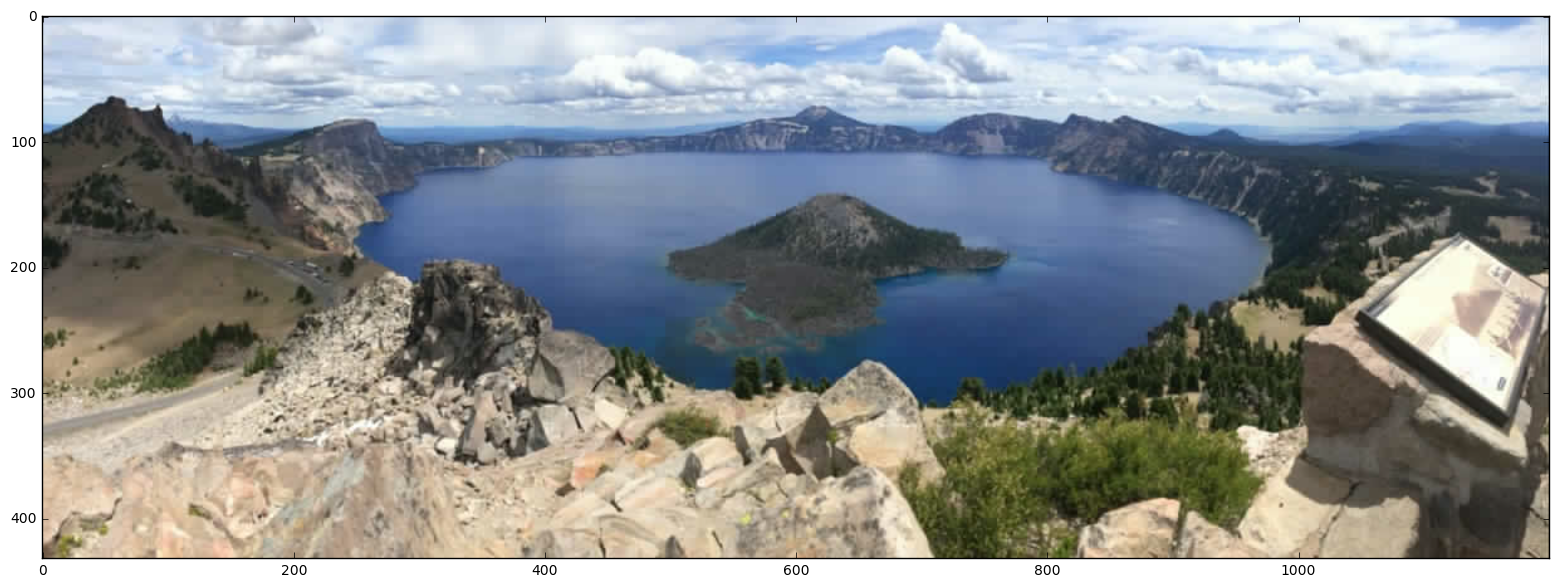

In [12]:
def recon_im(Yq, Crq, Cbq, H, W, h, w):
    Yw, Crw, Cbw = iquant(Yq, Crq, Cbq)
    print(" YW1", Yw)
    Yw = Yw.astype(float)
    print(" YW2", Yw)
    Crw = Crw.astype(float)
    Cbq = Cbq.astype(float)
    #print(Yw, Crw, Cbw)
    Y, Cr, Cb = idct_eight(Yw, Crw, Cbw, H, W)
    #print(Y, Cr, Cb)

    R, G, B = YCC2rgb_2(Y, Cr, Cb)
    
    print(R, G, B)
    im_re = np.zeros((h, w, 3))
    im_re[:,:,0] = R[:h,:w]
    im_re[:,:,1] = G[:h,:w]
    im_re[:,:,2] = B[:h,:w]
    print(np.where(im_re > 255))
    im_re[np.where(im_re > 255)] = 255
    im_re[np.where(im_re < 0)] = 0
    im_re = np.uint8(im_re)
    print(np.max(im_re))
    print(np.min(im_re))
    print(im_re)
    plt.imshow(im_re)
    #im = np.array[]
    #print(YCC2rgb_2(Y, Cr, Cb))
    
    return im_re
    
    
    

def recon_image(dct_im, thresh_plot = False):

    #Inverse Quantization
    dct_im = iquantize(dct_im,1)

    img = np.zeros(dct_im.shape)
    for i in r_[:dct_im.shape[0]:8]:
        for j in r_[:dct_im.shape[1]:8]:
            img[i:(i+8),j:(j+8)] = idct2( dct_im[i:(i+8),j:(j+8)] )

    #YCbCr to RGB
    recon_im = YCbCr2rgb(img) 

    #recon_im[np.where(recon_im > 1.0)] = 1.0
    #recon_im[np.where(recon_im < 0)] = 0.0

    if thresh_plot: 
        #Plotting
        plt.figure()
        plt.imshow(dct_thresh[:,:,0],cmap='gray',vmax = np.max(dct)*0.01,vmin = 0)
        plt.title( "Thresholded 8x8 DCTs of the image")

            
    
    percent_nonzeros = np.sum( dct_im != 0.0 ) / (dct_im.shape[0]*dct_im.shape[1]*dct_im.shape[2]*1.0)

    print ("Keeping only %f%% of the DCT coefficients" % (percent_nonzeros*100.0))
    
    plt.figure()
    plt.imshow( np.hstack((im,recon_im)))#+abs(np.min(recon_im)
    plt.title("Comparison between original, DCT compressed images" )
    
    return recon_im

print(im)
print(im.shape)
A, B, C, D, E, h, w = compress_image_2(im)
print("DSDSDS" , im)
reconIM = recon_im(A, B, C, D, E, h, w)

In [13]:
totalSum = sum([len(G[i]) for i in range(len(G))])
print(totalSum)
totalSum = sum([len(H[i]) for i in range(len(H))])
print(totalSum)
totalSum = sum([len(I[i]) for i in range(len(I))])
print(totalSum)
normal = 64 * len(A)
print(normal)
print(float(totalSum / (1.0 * normal)))
    
print(A[0])
print(G[0])
newY, newCr, newCb = undoZig(G, H, I)
#print(bytearray(newY)))
#Gbytes = G.bytes
#buff
print("Size of compressed image: " + str(G.nbytes + H.nbytes + I.nbytes) + " Bytes")
print("Size of original image: " + str(im.nbytes) + " Bytes")
print("Precent Compression: " + str(100.*im.nbytes / dct_thresh[np.nonzero(dct_thresh)].nbytes) + "%")
    

89060
11292
9725
518400
0.0187596450617
[[ 1664.     0.     0.     0.     0.     0.     0.     0.]
 [  -24.     0.     0.     0.     0.     0.     0.     0.]
 [    0.     0.     0.     0.     0.     0.     0.     0.]
 [  -14.     0.     0.     0.     0.     0.     0.     0.]
 [    0.     0.     0.     0.     0.     0.     0.     0.]
 [    0.     0.     0.     0.     0.     0.     0.     0.]
 [    0.     0.     0.     0.     0.     0.     0.     0.]
 [    0.     0.     0.     0.     0.     0.     0.     0.]]
[ 104.    0.   -2.    0.    0.    0.    0.    0.    0.   -1.]


AttributeError: 'list' object has no attribute 'nbytes'

In [ ]:
#print(im.nbytes)
#print(G.nbytes)
#print(len(G))
#print(H.nbytes)
#print(A.nbytes)
#print(G.shape, G[0])
#for i in G:
    #print(i.)
G, H, I = processZig(A, B, C)

print(A[0])
print(G[0])

[[[ 0  0 66]
  [ 0  0 66]
  [ 0  0 66]
  ..., 
  [ 0  0 66]
  [ 0  0 66]
  [ 1  0 66]]

 [[ 0  0 66]
  [ 0  0 66]
  [ 0  0 66]
  ..., 
  [18 11 66]
  [13  6 66]
  [ 0  0 66]]

 [[ 0  0 66]
  [ 0  0 66]
  [ 0  0 66]
  ..., 
  [ 0  0 67]
  [ 0  0 66]
  [20 12 66]]

 ..., 
 [[ 0  0 66]
  [23 17 66]
  [ 0  0 68]
  ..., 
  [ 0  0 66]
  [ 0  0 66]
  [ 0  0 66]]

 [[16 10 66]
  [ 0  0 68]
  [ 0  0 70]
  ..., 
  [ 0  0 66]
  [ 0  0 66]
  [ 0  0 66]]

 [[19 13 65]
  [ 0  0 69]
  [41 37 68]
  ..., 
  [ 0  0 66]
  [ 0  0 66]
  [ 0  0 66]]]


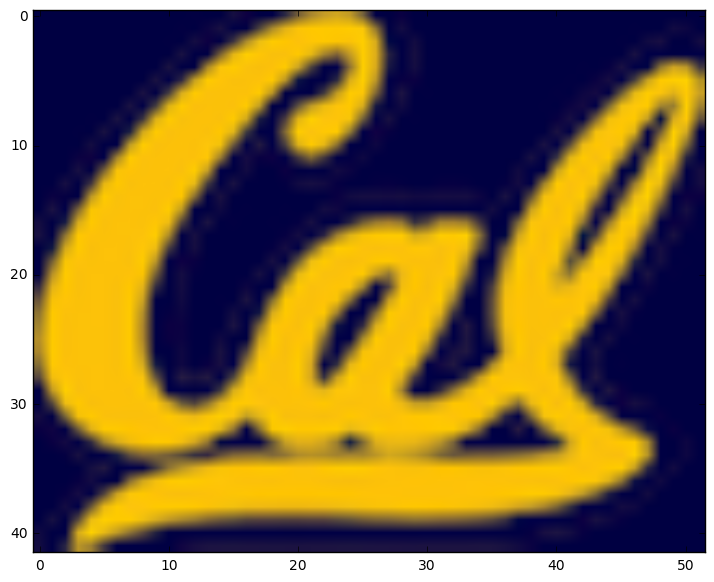

In [21]:
im = misc.imread("calBlue.tiff")#.astype(float)/255.
#im = misc.imread("createrLake.tiff")
# im = misc.imread("Isee.tiff").astype(float)/255.
# im = misc.imread("Marconi.tiff").astype(float)/255.
# im = misc.imread("pauly.tiff").astype(float)/255.
print(im)
plt.imshow(im)
##compress Image 
#print(im.shape)
#rec = (compress_image(im, 0.000,do_quantize=True))
#print(np.max(rec))
#print(np.min(rec))

##save Image 
#scipy.misc.imsave("rec.tiff",rec)

# ##Encode Image 
#tar = tarfile.open("rec.tar.gz", "w:gz")
#tar.add("rec.tiff")
#tar.close()



In [11]:
im = misc.imread("calBlue.tiff")#.astype(float)/255.
im = misc.imread("createrLake.tiff")

A, B, C, D, E = compress_image_2(im)



G, H, I = processZig(A, B, C)


(432L, 1200L)
(array([[ 194.615,  197.615,  200.615, ...,  193.978,  195.978,  112.978],
       [ 203.615,  205.088,  206.615, ...,  198.337,  201.337,  116.337],
       [ 208.088,  208.86 ,  209.088, ...,  202.821,  205.821,  117.821],
       ..., 
       [  89.341,   93.341,   99.694, ...,  167.162,  167.874,   98.874],
       [  89.808,   89.808,   88.808, ...,  168.803,  164.102,   90.113],
       [  82.036,   86.036,   93.036, ...,  161.803,  159.113,   91.113]]), array([[ 144.01866,  144.01866,  144.01866, ...,  147.19984,  147.19984,
         147.19984],
       [ 144.01866,  143.1874 ,  144.01866, ...,  145.86858,  145.86858,
         145.86858],
       [ 143.1874 ,  142.1874 ,  143.1874 , ...,  145.0311 ,  145.0311 ,
         145.0311 ],
       ..., 
       [ 115.95646,  115.95646,  117.45024, ...,  113.80016,  113.96268,
         113.96268],
       [ 117.95024,  117.95024,  117.95024, ...,  115.13142,  114.96268,
         114.95646],
       [ 118.95024,  118.95024,  118.95024,

ValueError: too many values to unpack

Keeping only 50.902649% of the DCT coefficients
PSNR: 7.4980950249db


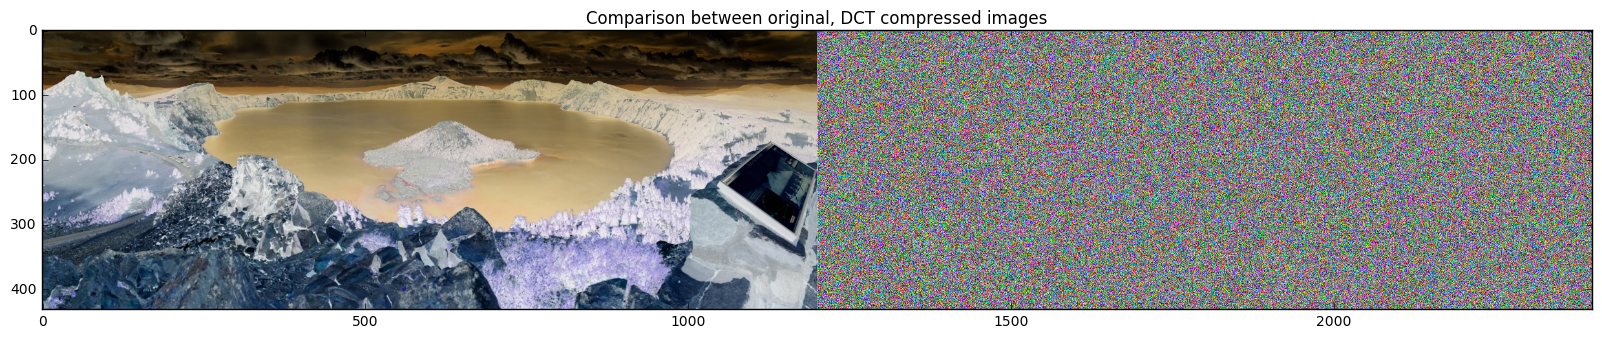

In [52]:
## Unpack 
tar = tarfile.open("rec.tar.gz", "r:gz")
tar.extractall()
tar.close()
r = misc.imread("rec.tiff")
# r = r - 127


##Reconstruct Image 
recon_im = recon_image(rec)
scipy.misc.imsave("recon_im.tiff", recon_im)



##Post Processing

print("PSNR: " + str(PSNR(im,recon_im)) + "db")

# Step 1: Preprocessing

### Converting to YCbCr

In [250]:
# #converting image into YCbCr format, and float 

#  ####### ####### ####### ####### ####### ####### ####### ####### ####### ####### #######
# ####### We need to check if we should flatten before and also if to scale by 255 ??? #######
#  ####### ####### ####### ####### ####### ####### ####### ####### ####### ####### #######


# im = misc.imread("calBlue.tiff").astype(float)/255.
# # im = misc.imread("createrLake.tiff").astype(float)/255.
# # im = misc.imread("Isee.tiff").astype(float)/255.
# # im = misc.imread("Marconi.tiff").astype(float)/255.
# # im = misc.imread("pauly.tiff").astype(float)/255.



#  ####### ####### ####### ####### ####### ####### ####### ####### ####### ####### #######
#  ####### ####### ####### ####### ####### ####### ####### ####### ####### ####### #######



# f = plt.figure()
# plt.imshow(im)

# print(im.shape)



In [251]:
# # print(iim.shape)
# iim= rgb2YCbCr(im) 
# # iim = im 
# f = plt.figure()
# plt.imshow(iim)


# Step 2: Transformation

### partition the image into blocks of size 8 x 8 pixels

In [253]:
# iimsize = iim.shape
# imsize = im.shape
# dct = np.zeros(imsize)
# # 
# # Do 8x8 DCT on image (in-place)
# for i in r_[:iimsize[0]:8]:
#     for j in r_[:iimsize[1]:8]:
#         dct[i:(i+8),j:(j+8)] = dct2( iim[i:(i+8),j:(j+8)] )
# # 
# # # Do 3x4 DCT on image (in-place)
# # for i in r_[:iimsize[0]:3]:
# #     for j in r_[:iimsize[1]:4]:
# #         dct[i:(i+3),j:(j+4)] = dct2( iim[i:(i+3),j:(j+4)] )


In [254]:
# pos = 24

# # Extract a block from image

# plt.figure()
# plt.imshow(im[pos:pos+8,pos:pos+8,0],cmap='gray',interpolation='none')
# plt.title( "An 8x8 Image block")

# # Display the dct of that block
# plt.figure()
# plt.imshow(dct[pos:pos+8,pos:pos+8,0],cmap='gray',vmax= np.max(dct)*0.01,vmin = 0, extent=[0,pi,pi,0],interpolation='none')
# plt.title( "An 8x8 DCT block")


In [255]:
# Display entire DCT
# plt.figure()
# plt.imshow(dct[:,:,0],cmap='gray',vmax = np.max(dct)*0.01,vmin = 0)
# plt.title( "8x8 DCTs of the image")


In [256]:
# # Threshold
# # thresh = 0.00001
# thresh = 0.0
# dct_thresh = dct * (abs(dct) > (thresh*np.max(dct)))


# # plt.figure()
# # plt.imshow(dct_thresh[:,:,0],cmap='gray',vmax = np.max(dct)*0.01,vmin = 0)
# # plt.title( "Thresholded 8x8 DCTs of the image")

# # percent_nonzeros = np.sum( dct_thresh != 0.0 ) / (imsize[0]*imsize[1]*imsize[2]*1.0)

# # print ("Keeping only %f%% of the DCT coefficients" % (percent_nonzeros*100.0))

# Step 3: Quantization

In [257]:
# dct_thresh = quantize(dct_thresh)


# Step 4: Encoding

## De-Quantize 

#### Note that this happens after we transmit the image ? 

In [258]:
# dct_thresh = iquantize(dct_thresh)

## Inverse Transform  

In [259]:
# im_dct = np.zeros(imsize)

# for i in r_[:iimsize[0]:8]:
#     for j in r_[:iimsize[1]:8]:
#         im_dct[i:(i+8),j:(j+8)] = idct2( dct_thresh[i:(i+8),j:(j+8)] )

# # # 3X4
# # for i in r_[:iimsize[0]:3]:
# #     for j in r_[:iimsize[1]:4]:
# #         im_dct[i:(i+3),j:(j+4)] = idct2( dct_thresh[i:(i+3),j:(j+4)] )


# recon_im = YCbCr2rgb(im_dct) 
# # recon_im += abs(np.min(recon_im))      

# plt.figure()
# plt.imshow( np.hstack((im,recon_im+abs(np.min(recon_im)))))
# plt.title("Comparison between original, DCT compressed images" )
    

In [260]:
print(PSNR(im,recon_im))

53.1793960371


In [261]:
print(EE123_psnr(im,recon_im , maxVal=255))

53.1793960371


In [ ]:
### Problems ###

##quantization: should i rescale, how to treat each different picture. 
##try zero padding 
##saturation causes those colors? 
##different image sizes
##post processing 
## when wavelet? dct? downsampling? 
##play with thresholds? loop until small enough?